# TensorFlow: Tabular Forecasting

*Climate Forecasting Using a 2D Time Series of Multi-Variate Features Over Shifting Windows.*

<img src="../../../_static/images/banner/temps.png" class="banner-photo"/>

Highly dimensional forecasting is another holy grail of deep learning. This process encodes information about the state of the future as a function of the states of the past. Here the learnable parameters of a neural network effectively serve as coefficients in an 'infinitely' long polynomial equation for predicting the future.

Most tutorials in this space focus on the stock market. To be fair, the NYSE provides a reliable source of uniformly distributed, time-stamped data. However, in this example we'll examine the climate of Delhi in order to predict both it's temperature and humidity in the future.

To do this, we'll use a sliding `aiqc.Window` wherein the past 25 days of data is used to predict the next 5 days of data. We'll study each 25 day interval (e.g. [0...24]) in the dataset and shift it forward by 5 days (e.g. [5...29]) to learn about the transformation it undergoes. 

> If you want to predict the *past* instead, switch `samples_train` to serve as the evaluation data with `samples_evaluate` as the training data.

---

## 💾 Data

Reference [Example Datasets](../../datasets.html) for more information.

This dataset is comprised of:

* *Features* = daily weather statistics (temperature, humidity, wind, pressure).

In [3]:
from aiqc import datum
df = datum.to_pandas('delhi_climate.parquet')
df.sample(5)

,day_of_year,temperature,humidity,wind,pressure
0,1,10.000000,84.500000,0.000000,1015.666667
1,2,7.400000,92.000000,2.980000,1017.800000
2,3,7.166667,87.000000,4.633333,1018.666667
3,4,8.666667,71.333333,1.233333,1017.166667
4,5,6.000000,86.833333,3.700000,1016.500000


In [2]:
from aiqc.orm import Dataset
dataset = Dataset.Tabular.from_df(df)

<AxesSubplot:title={'center':'Temperature'}>

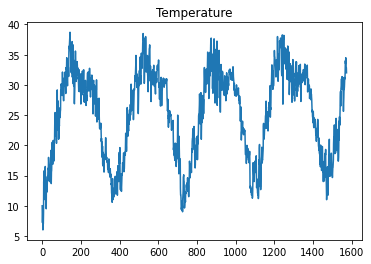

In [4]:
df['temperature'].plot(title='Temperature')

<AxesSubplot:title={'center':'Humidity'}>

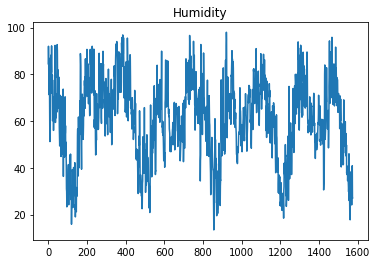

In [5]:
df['humidity'].plot(title='Humidity')

---

## 🚰 Pipeline

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [6]:
from aiqc.mlops import Pipeline, Input, Target, Stratifier
from sklearn.preprocessing import RobustScaler, StandardScaler

In [7]:
pipeline = Pipeline(
    inputs = Input(
        dataset         = dataset,
        exclude_columns = ['pressure','wind'],
        window          = Input.Window(size_window=25, size_shift=5),
        encoders        = Input.Encoder(
            StandardScaler(),
            dtypes = ['float64', 'int64']
        ),
    ),

    stratifier = Stratifier(
        size_test       = 0.12,
        size_validation = 0.18
    )
)


└── Info - System overriding user input to set `sklearn_preprocess.copy=False`.
	This saves memory when concatenating the output of many encoders.



---

## 🧪 Experiment

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [8]:
from aiqc.mlops import Experiment, Architecture, Trainer
import tensorflow as tf
from tensorflow.keras import layers as l

In [9]:
def fn_build(features_shape, label_shape, **hp):
    m = tf.keras.models.Sequential()
    if hp['LSTM_2']:
        m.add(l.LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=True
        ))
        m.add(l.LSTM(
            hp['neuron_count']
            , activation=hp['activation']
            , return_sequences=False
        ))
    else:
        m.add(l.LSTM(
            hp['neuron_count']
            , input_shape=(features_shape[0], features_shape[1])
            , activation=hp['activation']
            , return_sequences=False
        ))
    # Automatically flattens.
    m.add(l.Dense(label_shape[0]*label_shape[1]*hp['dense_multiplier'], activation=hp['activation']))
    m.add(l.Dropout(0.3))
    m.add(l.Dense(label_shape[0]*label_shape[1], activation=hp['activation'])) ### is this right shape?
    m.add(l.Dropout(0.3))
    # Reshape to be 3D.
    m.add(l.Reshape((label_shape[0], label_shape[1])))
    return m

In [10]:
def fn_train(
    model, loser, optimizer,
    train_features, train_label,
    eval_features, eval_label,
    **hp
):
    model.compile(
        loss        = loser
        , optimizer = optimizer
        , metrics   = ['mean_squared_error']
    )
        
    model.fit(
        train_features, train_label
        , validation_data = (eval_features, eval_label)
        , verbose         = 0
        , batch_size      = hp['batch_size']
        , epochs          = hp['epochs']
        , callbacks       = [tf.keras.callbacks.History()]
    )
    return model

In [11]:
hyperparameters = dict(
    LSTM_2             = [False]
    , activation       = ['tanh']
    , neuron_count     = [6]
    , batch_size       = [6]
    , epochs           = [150]
    , dense_multiplier = [1]
)

In [12]:
experiment = Experiment(
    Architecture(
        library           = "keras"
        , analysis_type   = "regression"
        , fn_build        = fn_build
        , fn_train        = fn_train
        , hyperparameters = hyperparameters
    ),
    
    Trainer(pipeline=pipeline, repeat_count=2)
)

In [13]:
experiment.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 2/2 [01:11<00:00, 35.89s/it]


---

## 📊 Visualization & Interpretation

For more information on visualization of performance metrics, reference the [Dashboard](../../dashboard.html) documentation.